Here is a training pipeline to classify cats and dogs using three NN.

What is below?
- 🗂 Download data from folder, 🐾 observe and 🧶 prepare it for training.
- Choose a model 🪷 (EfficientNet, RegNet, VIT) and put on info about it.
- 🪻 Train a model.

Intermediate metrics, misclassified images etc are stored in Tensorboard 📍. If you are curious about Class Activation Map please see it at the end.

_______________________________
Here I've collected parameters that can be changed quickly.

In [172]:
# Select model name for proper results tracking
model_name = 'VIT'
num_classes = 2
classes = ('Cat', 'Dog') # for probability picture output

# Training settings
batch_size = 32
subset_size = 3000
epochs = 5
lr = 1e-3
sch_gamma = 0.1
sch_step_size = 7
tboard_step_size = 5

# 🪇 Set up

## 📕 Libs

In [ ]:
# Standard 
import os
import random
import glob
import time
import numpy as np
from PIL import Image

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

# PyTorch Vision 
import torchvision
import torchvision.transforms as transforms

# Models and Grad-CAM
import timm
from efficientnet_pytorch import EfficientNet
from vit_pytorch.efficient import ViT
from linformer import Linformer
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# Scikit-learn for metrics
from sklearn.metrics import precision_score, recall_score, f1_score

# Visualization 
import matplotlib.pyplot as plt

# Device Configuration (CPU/GPU)
# Uncomment depending on the device availability
# device = ("cuda" if torch.cuda.is_available() else "cpu")
# device = ("mps" if torch.backends.mps.is_available() else "cpu")
device = 'cpu'

In [50]:
# for nice probability picture rendering, now think it is excessive
'''
def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds_tensor = preds_tensor.cpu()
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
'''

## ⚙️ Dir, writer, seed

In [144]:
# dir
proj_dir = "/Users/lune/ISP/proj1"
os.chdir(proj_dir) 

In [ ]:
# TensorBoard writer
writer = SummaryWriter('Catsdogs/runs/' + model_name)

In [173]:
# seed
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed = 42)

# 🗂 Dataset

## 🐾 Observe

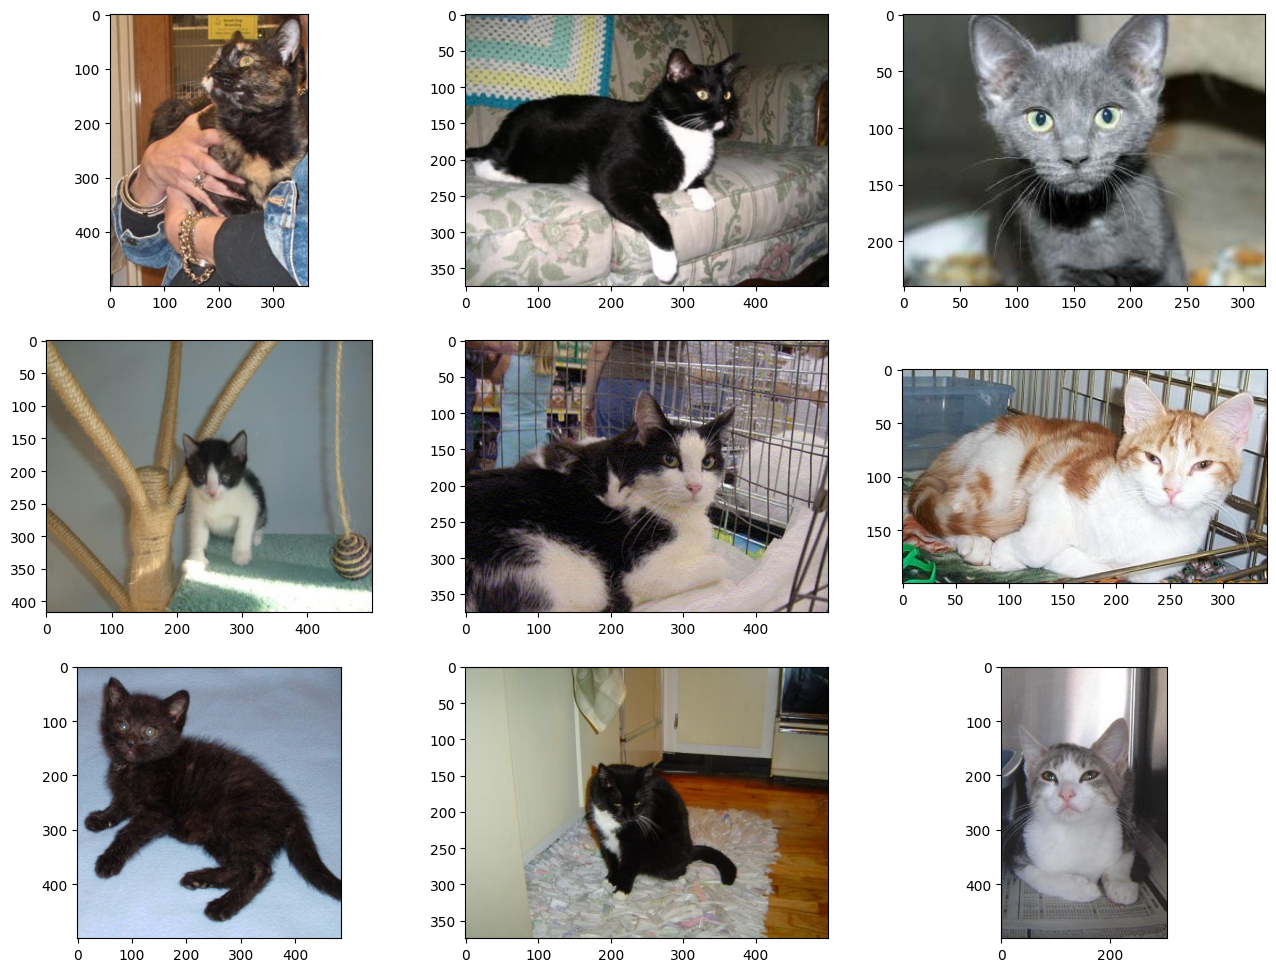

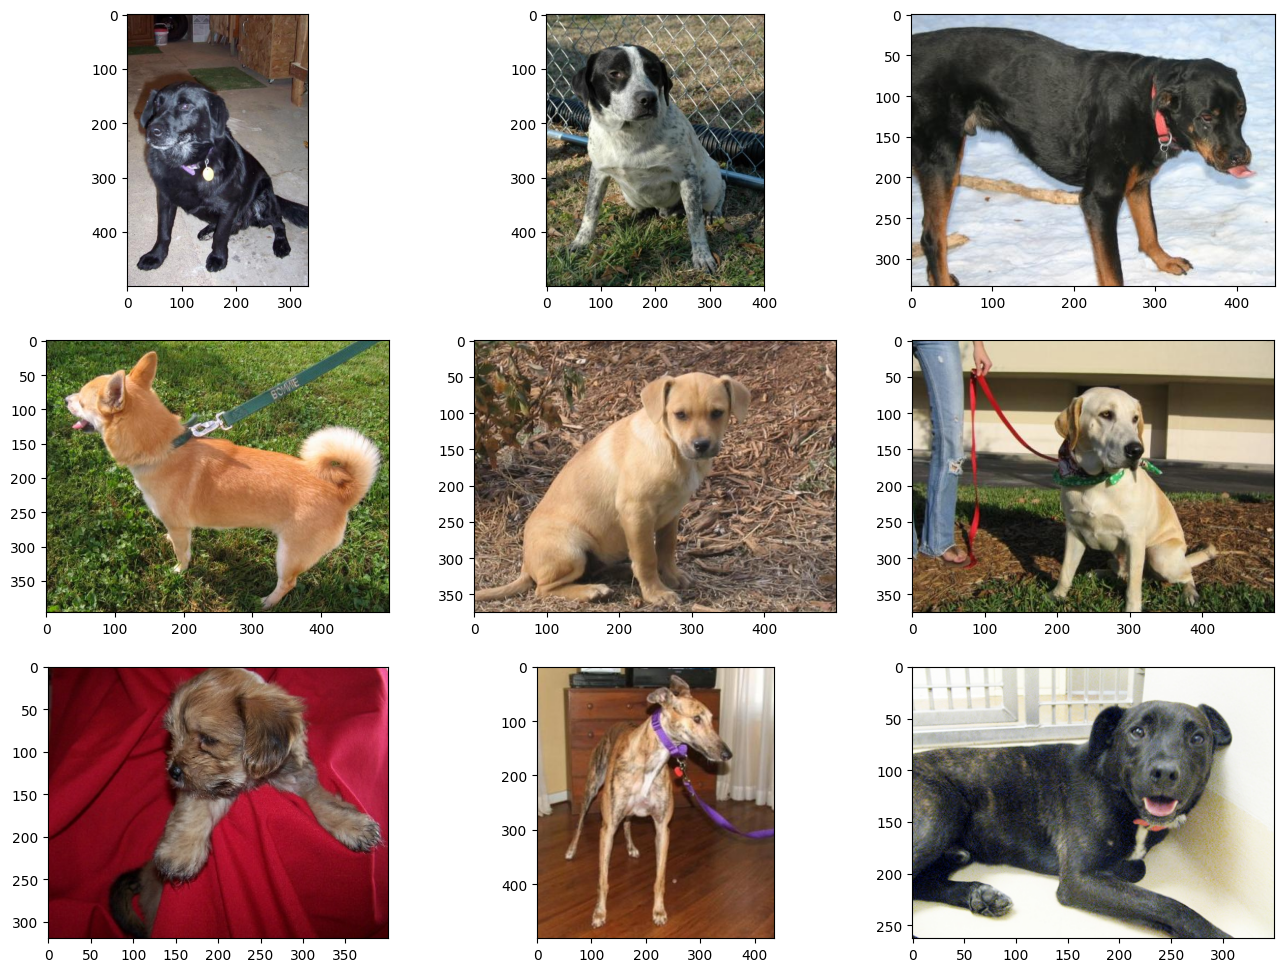

In [147]:
dataset_dir = proj_dir + '/Datasets/kagglecatsanddogs_5340/PetImages' # was initially downloaded from Microsoft site

# Cats
rdm_img_list = glob.glob(os.path.join(dataset_dir + "/Cat",'*.jpg'))
random_idx = np.random.randint(1, len(rdm_img_list), size=9)

fig, axes = plt.subplots(3, 3, figsize=(16, 12))
for idx, ax in enumerate(axes.ravel()):
    img = Image.open(rdm_img_list[idx])
    ax.imshow(img)

# Dogs
rdm_img_list = glob.glob(os.path.join(dataset_dir + "/Dog",'*.jpg'))
random_idx = np.random.randint(1, len(rdm_img_list), size=9)

fig, axes = plt.subplots(3, 3, figsize=(16, 12))
for idx, ax in enumerate(axes.ravel()):
    img = Image.open(rdm_img_list[idx])
    ax.imshow(img)

## 🧶 Transform, Subset, Split > DataLoader

In [ ]:
# Scheme:

# 1. ImageFolder (dir and transform)
# \__Subset (> subset_dataset)
# \__Train-test split (> train_dataset, val_dataset)
# 2. DataLoader (> train_loader, val_loader)
# 3. DataLoader check

In [148]:
# 1. ImageFolder---------------------------------------------------------------------------------------
# ImageFolder class to handle loading and preprocessing of image data stored in the directory
# (each subdirestory should correspond to a class)

# 1. Loading - when you initiate an ImageFolder it automatically loads the images and associates them 
# with their respective labels based on the subdirectory names
## label 0 to images in the cat/ folder
## label 1 to images in the dog/ folder (alphabetically)

# 2. Transforming - resize, convert to tensor format, normalize pixel values. Transformations are
# specified using the transforms parameter (accepts tranforms.Compose object containing the list of transformations to apply)

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    #transforms.RandomResizedCrop(224),
    #transforms.RandomHorizontalFlip(),
])

dataset = torchvision.datasets.ImageFolder(dataset_dir, transform=transform)

# \__Subset initial dataset (Use only the first 100 images)
indices = torch.randperm(len(dataset)).tolist()
subset_indices = indices[:subset_size]
subset_dataset = torch.utils.data.Subset(dataset, subset_indices)  # Get first 100 images

# \__Split input images into 80% training and 20% validation
train_size = int(0.8 * len(subset_dataset))  # 80% for training
val_size = len(subset_dataset) - train_size   # 20% for validation
train_dataset, val_dataset = torch.utils.data.random_split(subset_dataset, [train_size, val_size])

# 2. DataLoader---------------------------------------------------------------------------------------
# DataLoader class helps to 
# 1. Batch loading (train model not on the entire dataset at once, but rather in the subsets)
# 2. Shuffling - shuffle data at the beginning on the each epoch. It is needed to prevent the model from
# learning the order of the data (especially then the order of data might affect it - data is sorted by class)
# 3. Parallel processing - it can utilize multiple workers

# Create DataLoaders for both
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [149]:
# Example data (one batch from train)
examples = iter(train_loader)
example_data, example_labels = next(examples)

##### 📍 [image]

In [175]:
img_grid = torchvision.utils.make_grid(example_data, nrow=4, normalize=True)
writer.add_image('image', img_grid)

In [ ]:
# 3. DataLoader check----------------------------------------------------------------------------
# Show input anf label in the first batch in Train and Validation
'''
print("train_loader is:")
for inputs, labels in train_loader:
    print(f"Inputs batch shape: {inputs.shape}")
    print(f"Labels batch shape: {labels.shape}")
    print(f"Labels: {labels}")  # Print labels for the batch
    break  # Exit after the first batch

print("val_loader is:")
for inputs, labels in val_loader:
    print(f"Inputs batch shape: {inputs.shape}")
    print(f"Labels batch shape: {labels.shape}")
    print(f"Labels: {labels}")  # Print labels for the batch
    break  # Exit after the first batch
'''

# 🪷 Model

## Choice

### 1️⃣ EfficientNet

In [151]:
model = EfficientNet.from_pretrained('efficientnet-b0') 
model._fc = torch.nn.Linear(model._fc.in_features, num_classes)
model.to(device)

Loaded pretrained weights for efficientnet-b0


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

### 2️⃣ Regnet

In [165]:
model = timm.create_model('regnety_040', pretrained=True)
model.head.fc = torch.nn.Linear(model.head.fc.in_features, num_classes)
model.to(device)

RegNet(
  (stem): ConvNormAct(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
  )
  (s1): RegStage(
    (b1): Bottleneck(
      (conv1): ConvNormAct(
        (conv): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
      )
      (conv2): ConvNormAct(
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=2, bias=False)
        (bn): BatchNormAct2d(
          128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
      )
      (se): SEModule(
        (fc1): Conv2d(128, 8,

### 3️⃣ VIT

Variant 1

In [ ]:
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes)
model.to(device)

Variant 2 - now work with it

In [177]:
efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=2,
    transformer=efficient_transformer,
    channels=3,
).to(device)

## Model about

##### 📍 [graph, parameters, size]

In [178]:
writer.add_graph(model, example_data.to(device))

# Model Size and Number of Parameters
params = list(model.parameters()) # print(params[0].size())
print(f'Groups of parameters: {len(params)}')
#writer.add_text('Model_Info', f'Groups of parameters: {len(params)}')

num_tr_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of training parameters: {num_tr_params}')
#writer.add_text('Model_Info', f'Number of training parameters: {num_tr_params}')

model_size = sum(p.numel() for p in model.parameters() if p.requires_grad) * 4 / (1024 ** 2)  # Size in MB
print(f'Model Size: {model_size:.2f} MB')
#writer.add_text('Model_Info', f'Model Size Initial: {model_size_initial:.2f} MB')

summary(model, (3, 224, 224))

/opt/homebrew/lib/python3.11/site-packages/linformer/linformer.py:97: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert kv_len <= self.seq_len, f'the sequence length of the key / values must be {self.seq_len} - {kv_len} given'
/opt/homebrew/lib/python3.11/site-packages/linformer/linformer.py:112: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if kv_len < self.seq_len:


Groups of parameters: 192
Number of training parameters: 2858242
Model Size: 10.90 MB
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Rearrange-1             [-1, 49, 3072]               0
         LayerNorm-2             [-1, 49, 3072]           6,144
            Linear-3              [-1, 49, 128]         393,344
         LayerNorm-4              [-1, 49, 128]             256
         LayerNorm-5              [-1, 50, 128]             256
            Linear-6              [-1, 50, 128]          16,384
            Linear-7              [-1, 50, 128]          16,384
            Linear-8              [-1, 50, 128]          16,384
           Dropout-9            [-1, 8, 50, 64]               0
           Linear-10              [-1, 50, 128]          16,512
LinformerSelfAttention-11              [-1, 50, 128]               0
          PreNorm-12              [-1, 50, 128]               0
        Laye

In [ ]:
'''
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]}")  # prints first 2 values of the layer weights

for name, layer in model.named_children():
    print(f"Layer: {name}")
    for param_name, param in layer.named_parameters(recurse=False):
        print(f"  Parameter: {param_name}, Shape: {param.size()}")'''

# 🪻 Training

In [179]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr) # Optimizer Adam - method for stochastic optimization
criterion = torch.nn.CrossEntropyLoss() # Loss function
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=sch_step_size, gamma=sch_gamma)

##### 📍 [loss and accuracy]

In [ ]:
# epochs = n

for epoch in range(epochs):
    start_time = time.time()

    print(f'Epoch: {epoch+1}')

    # Train-------------------------------------------------------------------------------
    print('Training..')
    model.train() 

    running_loss = 0.0
    all_preds = []
    all_labels = []

    for i, (inputs, labels) in enumerate(train_loader):

        inputs, labels = inputs.to(device), labels.to(device)

        # forward pass
        optimizer.zero_grad() # clears old gradients 
        outputs = model(inputs) 
        loss = criterion(outputs, labels) 

        # backward pass
        loss.backward() # compute the gradient
        optimizer.step() # updates the models weights using the gradint

        # loss and prediction
        running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        step = tboard_step_size
        if (i+1) % step == 0:

            loss = running_loss / step
            accuracy = (torch.tensor(all_preds) == torch.tensor(all_labels)).sum().item() / len(all_labels)
            precision = precision_score(all_labels, all_preds, average='macro')
            recall = recall_score(all_labels, all_preds, average='macro')
            f1 = f1_score(all_labels, all_preds, average='macro')

            print(f'[Epoch {epoch + 1}, batch {i + 1:5d}] loss: {loss:.3f}, accuracy: {accuracy:.3f}, precision: {precision:.3f}, recall: {recall:.3f}, f1: {f1:.3f}')

            writer.add_scalar('train/loss', loss, epoch * len(train_loader) + i)
            writer.add_scalar('train/accuracy' , accuracy, epoch * len(train_loader) + i)
            writer.add_scalar('train/precision', precision, epoch * len(train_loader) + i)
            writer.add_scalar('train/recall' , recall, epoch * len(train_loader) + i)
            writer.add_scalar('train/f1', f1, epoch * len(train_loader) + i)
            
            running_loss = 0.0 
            all_preds = []
            all_labels = []

            # probability
            #writer.add_figure('probability',
            #                   plot_classes_preds(model, inputs, labels),
            #                   global_step=epoch * n_total_steps + i)  

            for name, param in model.named_parameters():
                if param.requires_grad:
                    layer_name = name
                    writer.add_histogram(f'{layer_name}/weights', param, epoch+1)
                    writer.add_histogram(f'{layer_name}/gradients', param.grad, epoch+1)
    
    end_time_training = time.time()
    inference_time = end_time_training - start_time

    # Validation-------------------------------------------------------------------------------
    print('Validation..')
    model.eval()

    running_loss = 0.0
    all_preds = []
    all_labels = []

    misclassified_images = []
    misclassified_labels = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            # forward pass
            outputs = model(inputs) 
            loss = criterion(outputs, labels) 

            # loss and accuracy
            running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # misclassified
            misclassified_mask = preds != labels
            if misclassified_mask.sum() > 0:
                misclassified_images.extend(inputs[misclassified_mask].cpu())
                misclassified_labels.extend(preds[misclassified_mask].cpu().numpy())

            step = tboard_step_size
            if (i+1) % step == 0:

                loss = running_loss / step
                accuracy = (torch.tensor(all_preds) == torch.tensor(all_labels)).sum().item() / len(all_labels)
                precision = precision_score(all_labels, all_preds, average='macro')
                recall = recall_score(all_labels, all_preds, average='macro')
                f1 = f1_score(all_labels, all_preds, average='macro')

                print(f'[Epoch {epoch + 1}, batch {i + 1:5d}] loss: {loss:.3f}, accuracy: {accuracy:.3f}, precision: {precision:.3f}, recall: {recall:.3f}, f1: {f1:.3f}')

                writer.add_scalar('val/loss', loss, epoch * len(val_loader) + i)
                writer.add_scalar('val/accuracy' , accuracy, epoch * len(val_loader) + i)
                writer.add_scalar('val/precision', precision, epoch * len(val_loader) + i)
                writer.add_scalar('val/recall' , recall, epoch * len(val_loader) + i)
                writer.add_scalar('val/f1', f1, epoch * len(val_loader) + i)
                
                running_loss = 0.0 
                all_preds = []
                all_labels = []

        if len(misclassified_images) > 0:
            grid = torchvision.utils.make_grid(misclassified_images, nrow=4, normalize=True)
            writer.add_image(f'misclassified_images/epoch_{epoch+1}', grid, epoch+1)

    scheduler.step() # adjust the learning rate

end_time_full = time.time()
full_time = end_time_full - start_time

writer.flush()

In [181]:
torch.save(model, proj_dir + '/Catsdogs/Models/' + model_name + '.pth')
#model = torch.load('model.pth')

In [182]:
print('####### Model info #######')
print(f'Model: {model_name} with {num_classes} classes: {classes}') 
print(f'Groups of parameters: {len(params)}')
print(f'Number of training parameters: {num_tr_params}')
print(f'Model Size: {model_size:.2f} MB')
print(f'Inference Time: {inference_time/60:.2f} min, Full time: {full_time/60:.2f}')
print('')
print('####### Data preprocessing #######')
print('Transform: .Resize((224,224)) .ToTensor() .Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])')
print('Augmentation: no')
print(f'Subset size: {subset_size}')
print(f'Train/Validation split: {train_size}/{val_size}')
print(f'Dataloader: batch_size={batch_size}, shuffle=True (train only), num_workers=4')
print('')
print('####### Training #######')
print(f'optimizer = torch.optim.Adam(model.parameters(), lr={lr})') 
print(f'criterion = torch.nn.CrossEntropyLoss()') 
print(f'scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size={sch_step_size}, gamma={sch_gamma})')
print(f'epochs = {epochs}')
print(f'TensorBoard step = {tboard_step_size}')

writer.add_text('Model_Info', 'Model: ' + model_name + f' with {num_classes} classes: {classes}')
writer.add_text('Model_Info', f'Groups of parameters: {len(params)}')
writer.add_text('Model_Info', f'Number of training parameters: {num_tr_params}')
writer.add_text('Model_Info', f'Model Size: {model_size:.2f} MB')
writer.add_text('Model_Info', f'Inference Time: {inference_time/60:.2f} min, Full time: {full_time/60:.2f}')

writer.add_text('Data_Preprocessing', 'Transform: .Resize((224,224)) .ToTensor() .Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])')
writer.add_text('Data_Preprocessing', 'Augmentation: no')
writer.add_text('Data_Preprocessing', f'Subset size: {subset_size}')
writer.add_text('Data_Preprocessing', f'Train/Validation split: {train_size}/{val_size}')
writer.add_text('Data_Preprocessing', f'Dataloader: batch_size={batch_size}, shuffle=True (train only), num_workers=4')

writer.add_text('Training_Settings', f'optimizer = torch.optim.Adam(model.parameters(), lr={lr})')
writer.add_text('Training_Settings', 'criterion = torch.nn.CrossEntropyLoss()')
writer.add_text('Training_Settings', f'scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size={sch_step_size}, gamma={sch_gamma})')
writer.add_text('Training_Settings', f'epochs = {epochs}')
writer.add_text('Training_Settings', f'TensorBoard step = {tboard_step_size}')

####### Model info #######
Model: VIT with 2 classes: ('Cat', 'Dog')
Groups of parameters: 192
Number of training parameters: 2858242
Model Size: 10.90 MB
Inference Time: 0.82 min, Full time: 1.34

####### Data preprocessing #######
Transform: .Resize((224,224)) .ToTensor() .Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
Augmentation: no
Subset size: 3000
Train/Validation split: 2400/600
Dataloader: batch_size=32, shuffle=True (train only), num_workers=4

####### Training #######
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
epochs = 5
TensorBoard step = 5


In [183]:
writer.close()

# CAM

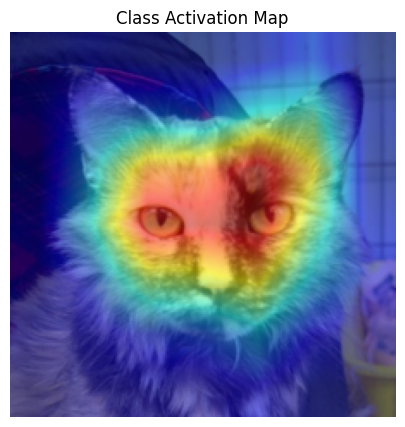

In [141]:
# Image to show-------------------------------------------------
image_path = proj_dir + "/Datasets/kagglecatsanddogs_5340/PetImages/Cat/10.jpg"

# Load the image with PIL
image = Image.open(image_path)
input_tensor = transform(image) #input_tensor = torch.randn(1, 3, 224, 224)
image = image.resize((224, 224))
image = image.convert('RGB')

# to np array
image_np = np.array(image)
image_np = image_np.astype(np.float32)
image_np /= 255.0

# CAM------------------------------------------------------------
# last layer that will be used for generating the CAM
target_layers = [model._blocks[-1]]

cam = GradCAM(model=model, target_layers=target_layers)

target_category = None  # Or specify the class you want to visualize
grayscale_cam = cam(input_tensor.unsqueeze(0), target_category)  # Add batch dimension
grayscale_cam = grayscale_cam[0, :]  # Remove batch dimension

# Vizualization---------------------------------------------------
visualization = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)

plt.figure(figsize=(10, 5))  # Set the figure size as desired
plt.imshow(visualization)  # Show the image
plt.axis('off')  # Hide axes
plt.title('Class Activation Map')  # Optional: add a title
plt.show()